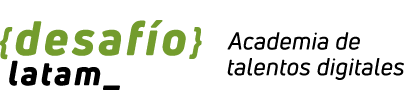
#<center><font color = 'green'>Entrenando un modelo de ensamble paralelo Random Forest</font></center>

# Importando librerías y datos
Se agrega una librería para trabajar con un modelo Random Forest para problemas de regresión.


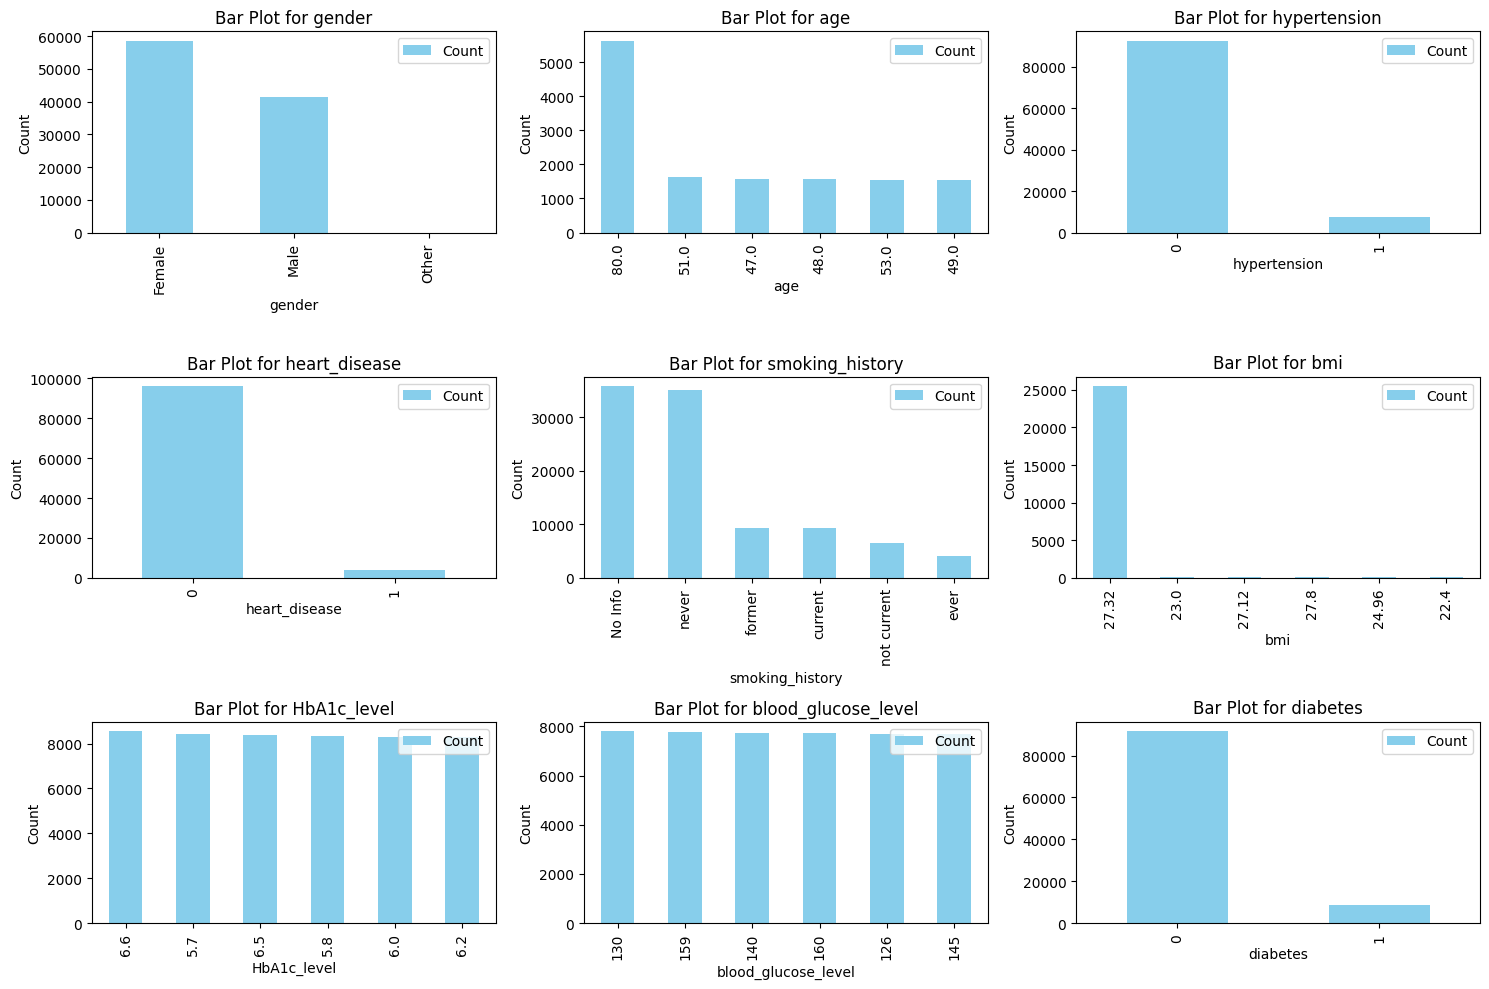

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

df = pd.read_csv('diabetes_prediction_dataset.csv')
df.sample(5)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Crear gráfico de barras agrupado para cada variable en la cuadrícula
for i, column in enumerate(df.columns):
    row, col = divmod(i, 3)
    ax = axes[row, col]

    # Agrupar los datos y contar las frecuencias
    grouped_data = df[column].value_counts().reset_index()
    grouped_data.columns = [column, 'Count']

    # Limitar a 6 barras como máximo
    top_categories = grouped_data.head(6)

    # Crear el gráfico de barras
    top_categories.plot(kind='bar', x=column, y='Count', color='skyblue', ax=ax)

    ax.set_title(f'Bar Plot for {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Ajustar el diseño y mostrar los gráficos
plt.tight_layout()
plt.show()


Cabe destacar el desbalance en la variable objetivo (tener o no  diabetes) Además, vemos que la edad promedio de los pacientes está en los 40 años con distribución concentrada en los 80 años, y que la muestra cuenta con más mujeres que hombres.


## Preprocesamiento y división de datos en entrenamiento y test


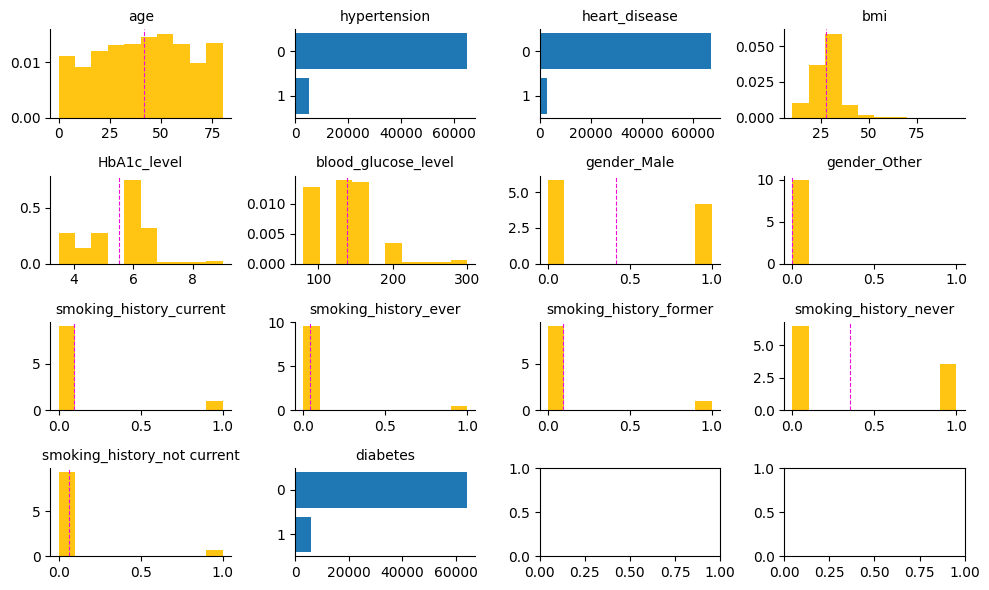

In [2]:
RANDOM_STATE = 202310

# variables nominales se convierten en binarias
df_dummies = pd.get_dummies(df.loc[:,['gender', 'smoking_history']], drop_first=True).astype(int).reset_index(drop=True)
df_dummies = pd.concat([df.drop(columns=['gender', 'smoking_history'], axis=1), df_dummies], axis=1)

X = df_dummies.drop(columns=['diabetes'], axis=1)
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

def plot_descriptive(df, ncols=3, max_discrete=12, figsize=(13, 6),
                     plot_type='hist', target='', fontsize=10):
    '''
    plot_type: acepta valores in ['hist', 'boxplot']
    '''
    nrows = df.shape[1]//ncols
    if nrows*ncols < df.shape[1]:
        nrows += 1

    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)

    i = 0
    for idx, (colname, serie)  in enumerate(df.items()):
        j = (idx % ncols)
        ax[i,j].set_title(colname, fontsize=fontsize)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)

        if (serie.dtype == 'object') or (
            serie.dtype == 'int64' and serie.unique().shape[0] <= max_discrete):
            serie = serie.value_counts().sort_values(ascending=True)

            ax_aux = ax[i,j].barh(
                y=np.array(serie.index).astype('str'),
                    width=serie.values,
            )
        else:
            if plot_type == 'hist':
                ax[i,j].hist(x=serie, color='xkcd:sunflower', density=True)
                ax[i,j].axvline(x=np.mean(serie), color='xkcd:fuchsia', ls='--', lw=0.8)
            elif plot_type == 'boxplot':
                ax[i,j].boxplot(serie)
                ax[i,j].set_xticklabels([''])

        if (j == ncols-1): i += 1

    plt.tight_layout()
    plt.show()






plot_descriptive(pd.concat([X_train, y_train], axis=1), figsize=(10, 6), ncols=4)


## Entrenamiento del modelo y evaluación

Para manejar el problema de desbalance de clase, usamos el parámetro class_weight con valor ‘balanced’, el cual permite controlar automáticamente el desequilibrio de clases asignando pesos inversamente proporcionales a las frecuencias de clase.


In [3]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE, oob_score=True, class_weight='balanced')
rf_model.fit(X_train, y_train)

yhat = rf_model.predict(X_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     27531
           1       0.95      0.67      0.79      2469

    accuracy                           0.97     30000
   macro avg       0.96      0.84      0.89     30000
weighted avg       0.97      0.97      0.97     30000



Se registra buenos indicadores en precisión tanto para sin diabetes como con diabetes con 0.97 y 0.95 respectivamente. Sin embargo, para la sensibilidad el modelo sólo es capaz de clasificar en forma correcta el 67% del total de casos con la enfermedad en la muestra de test y en cuanto al f1-score en promedio se registra un 0.89.

## Importancia de los atributos


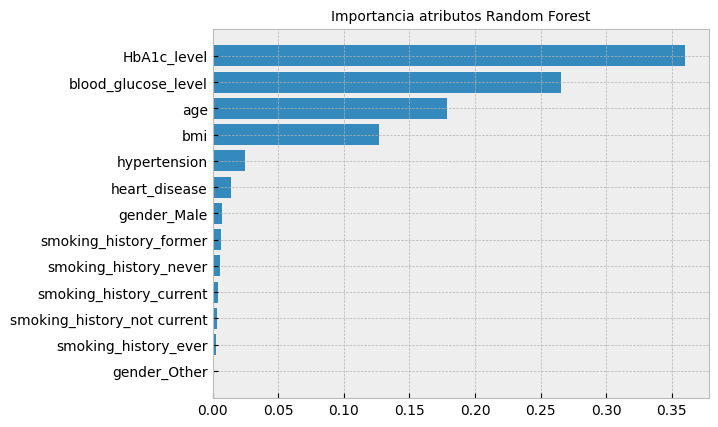

In [4]:
plt.style.use('bmh')

df_importance = pd.DataFrame({
    'atributo': rf_model.feature_names_in_,
    'importancia': rf_model.feature_importances_
}).sort_values(by='importancia', ascending=True)

plt.title('Importancia atributos Random Forest', fontsize=10)
plt.barh(y=df_importance['atributo'], width=df_importance['importancia']);


En este caso, observamos que la variable más importante detectada con Random Forest es el nivel promedio de azúcar en sangre de los últimos tres meses (HbA1c), y el segundo atributo importante que está relacionado con el anterior es el nivel de glucosa en sangre. El tercer factor en imortancia es la edad de los pacientes, y el cuarto factor es el índice de masa corporal.

## Controlando la aleatoriedad de atributos en Random Forest

Para controlar la cantidad de atributos que serán escogidos en forma aleatoria por cada estimador se cuenta con el parámetro max_features. Breiman (2001) propone que una buena forma de calibrar este hiper parámetro es calculando el logaritmo (log2) de la cantidad de atributos. sklearn permite usar otros, como la raíz cuadrada de la cantidad de atributos (sqrt). Además, se puede fijar esta cantidad igual a la cantidad de atributos transformado el modelo en un Bagging.

Para sintonizar el mejor valor para el hiper parámetro max_features mediante los valores que este soporta ( log2, sqrt, o None), entrenaremos modelos Random Forest variando la cantidad de estimadores entre 30 y 150 con paso **m** a elección (**OBSERVACIÓN:** puedes ir cambiando este valor disminuyéndolo, para conseguir mayor cantidad de pruebas. Esto puede hacer aumentar mucho el tiempo de ejecución). Así, calcularemos cada vez el error de estimación en OOB y el error calculado sobre la muestra de test. Esto se realizará  para cada uno de los tres valores que permite el hiper parámetro max_features.


In [5]:
df_accuracy_error = pd.DataFrame({
    'n_est': [], 'oob_none':[], 'oob_sqrt': [], 'oob_log2': [],
    'test_none':[], 'test_sqrt': [], 'test_log2': []
})

m = 10 #puedes disminuir este valor hasta llegar a 1, dependiendo de la capacidad de tu computador

for n_est in range(30, 150, 10):
    rf_model_none = RandomForestClassifier(
        random_state=RANDOM_STATE,
        oob_score=True,
        n_estimators=n_est,
        max_features=None,
        class_weight='balanced',
        n_jobs=-1
    ).fit(X_train, y_train)

    rf_model_sqrt = RandomForestClassifier(
        random_state=RANDOM_STATE,
        oob_score=True,
        n_estimators=n_est,
        max_features='sqrt',
        class_weight='balanced',
        n_jobs=-1
    ).fit(X_train, y_train)

    rf_model_log2 = RandomForestClassifier(
        random_state=RANDOM_STATE,
        oob_score=True,
        n_estimators=n_est,
        max_features='log2',
        class_weight='balanced',
        n_jobs=-1
    ).fit(X_train, y_train)

    df_accuracy_error = pd.concat([
        df_accuracy_error,
        pd.DataFrame({
            'n_est': [n_est],
            'oob_none':[1-rf_model_none.oob_score_],
            'oob_sqrt': [1-rf_model_sqrt.oob_score_],
            'oob_log2': [1-rf_model_log2.oob_score_],
            'test_none': [1-accuracy_score(y_test, rf_model_none.predict(X_test))],
            'test_sqrt': [1-accuracy_score(y_test, rf_model_sqrt.predict(X_test))],
            'test_log2': [1-accuracy_score(y_test, rf_model_log2.predict(X_test))]
        })
    ], axis=0)


Una vez calculadas nuestras medidas de error, se procede a representarlas en forma gráfica.

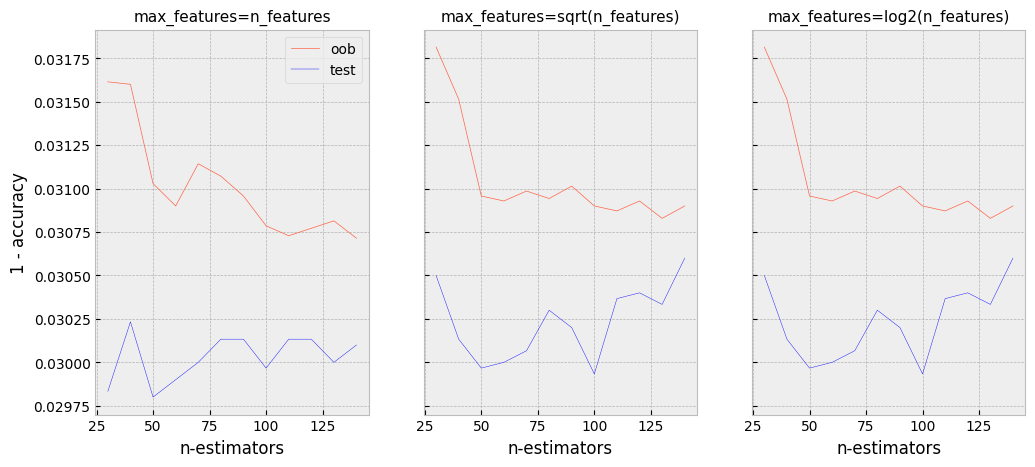

In [6]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(12, 5))

ax[0].set_title('max_features=n_features', fontsize=11)
ax[0].set_xlabel('n-estimators')
ax[0].set_ylabel('1 - accuracy')
ax[0].plot(df_accuracy_error['n_est'], df_accuracy_error['oob_none'], '-', color='tomato', label='oob', lw=0.5)
ax[0].plot(df_accuracy_error['n_est'], df_accuracy_error['test_none'], '-', color='blue', label='test', lw=0.3)
ax[0].legend()

ax[1].set_title('max_features=sqrt(n_features)', fontsize=11)
ax[1].set_xlabel('n-estimators')
ax[1].plot(df_accuracy_error['n_est'], df_accuracy_error['oob_sqrt'], '-', color='tomato', label='oob', lw=0.5)
ax[1].plot(df_accuracy_error['n_est'], df_accuracy_error['test_sqrt'], '-', color='blue', label='test', lw=0.3)

ax[2].set_title('max_features=log2(n_features)', fontsize=11)
ax[2].set_xlabel('n-estimators')
ax[2].plot(df_accuracy_error['n_est'], df_accuracy_error['oob_log2'], '-', color='tomato', label='oob', lw=0.5)
ax[2].plot(df_accuracy_error['n_est'], df_accuracy_error['test_log2'], '-', color='blue', label='test', lw=0.3);

Se aprecian resultados idénticos para sqrt y log2 y que estos últimos superan a None (n_features) en cuanto a que presentan errores (1-accuracy) menores.